In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import seaborn as sns

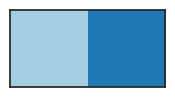

In [2]:
# Setting style
from matplotlib import rcParams
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
sns.set_style('white')
sns.set_palette("Paired", 2) #colorblind
sns.palplot(sns.color_palette())

In [3]:
# Reading the data, which can be downloaded here:
# http://ict.icrar.org/cutout/G10/dataRelease.php
tb4 = Table.read('../G10CosmosCatv04/G10CosmosCatv04.csv')
# Changing strange column names with spurious D
tb4['IA427_08_ERR'] = tb4['DIA427_08_ERR']
tb4['KC_08_ERR'] = tb4['DKC_08_ERR']

In [4]:
# Show column names
np.array(tb4.colnames)

array(['CATAID', 'ID_06', 'RA_06', 'DEC_06', 'I_FWHM_06', 'I_STAR_06',
       'I_MAG_AUTO_06', 'AUTO_FLAG_06', 'U_06', 'U_06_ERR', 'B_06',
       'B_06_ERR', 'V_06', 'V_06_ERR', 'G_06', 'G_06_ERR', 'R_06',
       'R_06_ERR', 'I_06', 'I_06_ERR', 'Z_06', 'Z_06_ERR', 'K_06',
       'K_06_ERR', 'I_CFHT_06', 'I_CFHT_06_ERR', 'U_SDSS_06',
       'U_SDSS_06_ERR', 'G_SDSS_06', 'G_SDSS_06_ERR', 'R_SDSS_06',
       'R_SDSS_06_ERR', 'I_SDSS_06', 'I_SDSS_06_ERR', 'Z_SDSS_06',
       'Z_SDSS_06_ERR', 'F814W_06', 'F814W_06_ERR', 'NB816_06',
       'NB816_06_ERR', 'LOGMASS_06', 'STAR_06', 'B_MASK_06', 'V_MASK_06',
       'I_MASK_06', 'Z_MASK_06', 'ID_08', 'RA_08', 'DEC__08', 'I_FWHM_08',
       'I_STAR_08', 'I_AUTO_08', 'AUTO_FLAG_08', 'U_08', 'U_08_ERR',
       'B_08', 'B_08_ERR', 'V_08', 'V_08_ERR', 'G_08', 'G_08_ERR', 'R_08',
       'R_08_ERR', 'I_08', 'I_08_ERR', 'Z_08', 'Z_08_ERR', 'K_08',
       'K_08_ERR', 'IC_08', 'IC_08_ERR', 'U_SDSS_08', 'U_SDSS_08_ERR',
       'G_SDSS_08', 'G_SDSS_08_ERR',

In [5]:
# Some sanity checks to see which objects have spectroscopic redshifts.
# Hopefully this should be equivalent to using Z_BEST with the flag Z_USE < 3
# and indeed, we recover similar numbers.
ind_vvds = tb4['Z_VVDS'] > 0
ind_vvds &= tb4['Z_VVDS'] < 4
ind_sdss = tb4['Z_SDSS'] > 0
ind_sdss &= tb4['Z_SDSS'] < 4
ind_sdss &= tb4['Z_ERR_SDSS'] < 0.001
ind_primus = tb4['Z_PRIMUS'] > 0
ind_primus &= tb4['Z_PRIMUS'] < 4
ind_primus &= tb4['ZQUALITY_PRIMUS'] >= 4
ind_zcosmos = tb4['Z_ZCOS'] > 0
ind_zcosmos &= tb4['Z_ZCOS'] < 4
ind_zcosmos &= tb4['ZQUALITY_ZCOS'] >= 4
ind = ind_sdss | ind_vvds | ind_primus | ind_zcosmos
ind.sum(), ind.size

(16084, 438226)

In [6]:
# Selecting objects with spectroscopic redshifts
ind_goodzspec = tb4['Z_USE'] < 3
ind_goodzspec &= tb4['Z_BEST'] > 0.0001
#ind_goodzspec &= tb4['Z_BEST'] < 0.2
# good extinction
ind_goodebv = tb4['EB_V_08'] > 0
# Not crazy photo-z's (because that would indicate a problem in the photometry)
ind_goodphotoz = (tb4['Z_BEST'] - tb4['ZP_COSMOS2015']) < 0.5
# and galaxies only.
ind_gal = tb4['CLASS_SDSS'] == 'GALAXY' 
ind_gal |= tb4['STAR_GALAXY_CLASS'] == 0
ind_gal &= tb4['ZQUALITY_EYE'] != 10
# The total number is:
print((ind_goodzspec & ind_goodebv & ind_goodphotoz & ind_gal).sum())

# Now select the bands by their names, and also copy EBV values.
yr = '_08'
subaru_bands = [
    'B', 'V', 'G', 'R', 'I', 'Z',
    'NB816', 'IA427', 'IA464', 'IA505', 'IA574', 
    'IA709', 'IA827', 'NB711', 'IA484', 'IA527', 
    'IA624', 'IA679', 'IA738', 'IA767']
subaru_abebv = [
    4.039, 3.147, 3.738, 2.586, 1.923, 1.436,
    1.745, 4.260, 3.843, 3.425, 2.937, 
    2.289, 1.747, 2.268, 3.621, 3.264, 
    2.694, 2.430, 2.150, 1.996]
sdss_bands = ['U_SDSS', 'G_SDSS', 'R_SDSS', 'I_SDSS', 'Z_SDSS']
sdss_abebv = [4.239, 3.303, 2.285, 1.698, 1.263]
ctiokpno_bands = ['K']
ctiokpno_abebv = [0.302]
hst_dands = ['F814W']
hst_abebv = [1.536]
ukirt_bands = ['J']
ukirt_abebv = [0.709]

# Which bands are we considering?
bands = subaru_bands + sdss_bands + ctiokpno_bands + hst_dands + ukirt_bands
abebvs = subaru_abebv + sdss_abebv + ctiokpno_abebv + hst_abebv + ukirt_abebv

ZP = 12.5 # arbitrary zero point to obtain reasonnable flux numbers
# Convert magnitudes to fluxes and correct for extinction
for abebv, b in zip(abebvs, bands):
    nm = b + yr
    nme = b + yr + '_ERR'
    themag = tb4[nm]
    themag += tb4['EB_V_08'] * abebv
    theflux = 10**(-0.4*(themag - ZP))
    thefluxerr = (10.**(.4*tb4[nme])-1.) * theflux
    tb4[b+'_FLUX'] = theflux
    tb4[b+'_FLUXVAR'] = np.abs(thefluxerr**2)

23702


/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: overflow encountered in power


In [20]:
# Selection for the training and target sets, mostly SNR cuts on top of having spec-z's
ind1 = ind_goodzspec & ind_goodebv & ind_goodphotoz & ind_gal
ind2 = ind_goodzspec & ind_goodebv & ind_goodphotoz & ind_gal
ind1 &= tb4['Z_BEST'] < 1.5
ind2 &= tb4['Z_BEST'] < 1.5
for b in subaru_bands + ctiokpno_bands + hst_dands + ukirt_bands:
    ind1 &= np.isfinite(tb4[b+'_FLUX'] / tb4[b+'_FLUXVAR']**0.5)
    ind1 &= tb4[b+'_FLUX'] / tb4[b+'_FLUXVAR']**0.5 > 2
for b in ['R_SDSS', 'I_SDSS']:
    ind2 &= tb4[b+'_FLUX'] / tb4[b+'_FLUXVAR']**0.5 > 5
for b in sdss_bands:
    ind2 &= np.isfinite(tb4[b+'_FLUX'] / tb4[b+'_FLUXVAR']**0.5)
    ind2 &= tb4[b+'_FLUX'] / tb4[b+'_FLUXVAR']**0.5 > 1
sel1 = np.where(ind1)[0]
sel2 = np.where(ind2)[0]
# remove duplicates
sel1 = sel1[~np.in1d(sel1, sel2)] 
# shuffle, just in case
np.random.shuffle(sel1)
np.random.shuffle(sel2)
print(sel1.size, sel2.size) # should be about 10,000 each!

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid valu

9923 8699


/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide


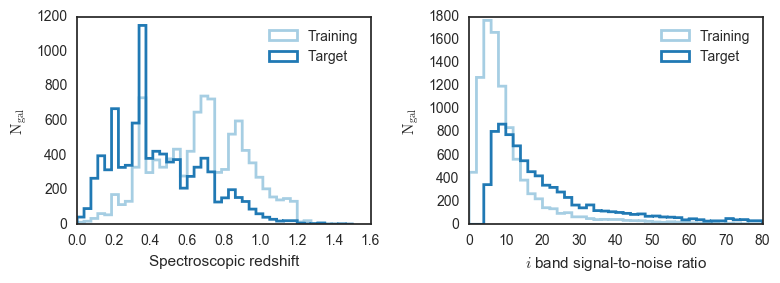

In [33]:
# Compare training and target: plot N(z) and imag SNR
normed = False
nbins = 40
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].hist(tb4['Z_BEST'][sel1], nbins, range=[0, 1.5], histtype='step', lw=2, label='Training', normed=normed)
axs[0].hist(tb4['Z_BEST'][sel2], nbins, range=[0, 1.5], histtype='step', lw=2, label='Target', normed=normed)
axs[0].legend()
axs[0].set_xlabel('Spectroscopic redshift')
axs[0].set_ylabel('$\mathrm{N}_\mathrm{gal}$')

b = 'I_SDSS'
nm = b + '_FLUX'
nme = b + '_FLUXVAR'
ratio1 = tb4[nm][sel1] / tb4[nme][sel1]**0.5
ratio1 = ratio1[np.isfinite(ratio1)]
ratio2 = tb4[nm][sel2] / tb4[nme][sel2]**0.5
ratio2 = ratio2[np.isfinite(ratio2)]
axs[1].hist(ratio1, nbins, histtype='step', lw=2, label='Training', range=[0, 80])
axs[1].hist(ratio2, nbins, histtype='step', lw=2, label='Target', range=[0, 80])
axs[1].legend()
axs[1].set_xlabel('$i$ band signal-to-noise ratio')
axs[1].set_ylabel('$\mathrm{N}_\mathrm{gal}$')

fig.tight_layout()
fig.savefig('../paper/training_vs_target.pdf')

In [60]:
# write a subset to ascii files
maxnum = 15000
names3 = list(np.concatenate([[nm + '_FLUX', nm + '_FLUXVAR'] for nm in bands])) + ['Z_BEST']
tb4[names3][sel1[:maxnum]].write('/Users/bl/Dropbox/repos/PhotoZviaGP/data/galaxies-fluxredshifts.txt', 
                             format='ascii.no_header')

In [61]:
maxnum = 15000
tb4[names3][sel2[:maxnum]].write('/Users/bl/Dropbox/repos/PhotoZviaGP/data/galaxies-fluxredshifts2.txt',
                              format='ascii.no_header')

In [12]:
# pretty print band + band_var names, for delight input file
' '.join(list(np.concatenate([[nm, nm + '_var'] for nm in bands])) + ['redshift'])

'B B_var V V_var G G_var R R_var I I_var Z Z_var NB816 NB816_var IA427 IA427_var IA464 IA464_var IA505 IA505_var IA574 IA574_var IA709 IA709_var IA827 IA827_var NB711 NB711_var IA484 IA484_var IA527 IA527_var IA624 IA624_var IA679 IA679_var IA738 IA738_var IA767 IA767_var U_SDSS U_SDSS_var G_SDSS G_SDSS_var R_SDSS R_SDSS_var I_SDSS I_SDSS_var Z_SDSS Z_SDSS_var K K_var F814W F814W_var J J_var redshift'

In [57]:
# write a smaller subset to ascii files
maxnum = 1000
names3 = list(np.concatenate([[nm + '_FLUX', nm + '_FLUXVAR'] for nm in bands])) + ['Z_BEST']
tb4[names3][sel1[:maxnum]].write('/Users/bl/Dropbox/repos/PhotoZviaGP/data/galaxies-fluxredshifts_small.txt', 
                             format='ascii.no_header')
tb4[names3][sel2[:maxnum]].write('/Users/bl/Dropbox/repos/PhotoZviaGP/data/galaxies-fluxredshifts_small2.txt',
                              format='ascii.no_header')

In [13]:
# print band names
len(bands), ' '.join(bands)

(28,
 'B V G R I Z NB816 IA427 IA464 IA505 IA574 IA709 IA827 NB711 IA484 IA527 IA624 IA679 IA738 IA767 U_SDSS G_SDSS R_SDSS I_SDSS Z_SDSS K F814W J')